In [1]:
!!nvidia-smi

['Thu Nov 21 06:47:37 2024       ',
 '+-----------------------------------------------------------------------------------------+',
 '| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |',
 '|-----------------------------------------+------------------------+----------------------+',
 '| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |',
 '|                                         |                        |               MIG M. |',
 '|=========================================+========================+======================|',
 '|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |',
 '| N/A   69C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |',
 '|                                         |                        |                  N/A |',
 '+-

In [2]:
!pip install tensorflow scikit-learn matplotlib scipy

In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
import os
import numpy as np
import scipy.io
import tarfile
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import  BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.regularizers import l2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [5]:
# Extract the flower images
with tarfile.open('/kaggle/input/flower/102flowers.tgz', 'r:gz') as tar:
    tar.extractall('./flowers')

# Extract the segmentation masks (optional for this task)
with tarfile.open('/kaggle/input/flower/102segmentations.tgz', 'r:gz') as tar:
    tar.extractall('./segmentations')

# extracting sample from data set associated with its class****

Extracting flower images...
Locating image files...
Total images found: 8189
Loading labels...
Loaded 8189 labels.
Loading data splits...
Number of training samples: 1020
Number of validation samples: 1020
Number of test samples: 6149
Adjusting indices...
Displaying sample images...


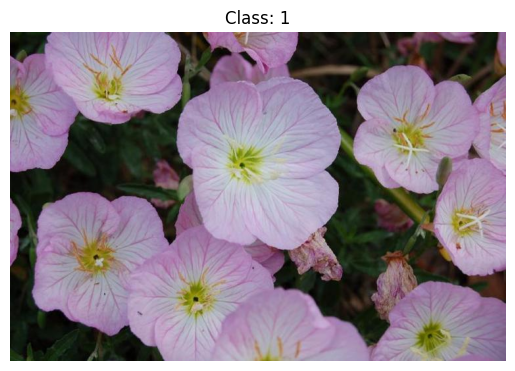

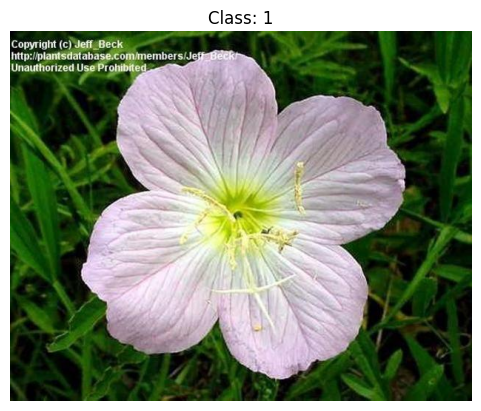

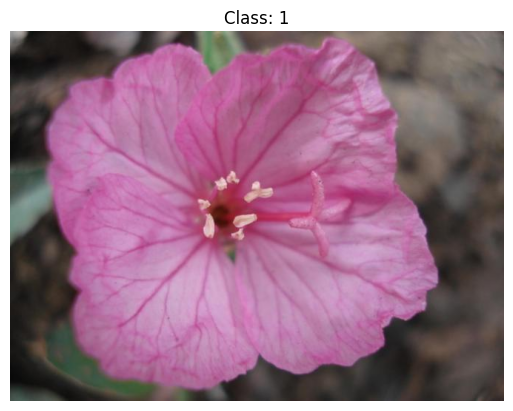

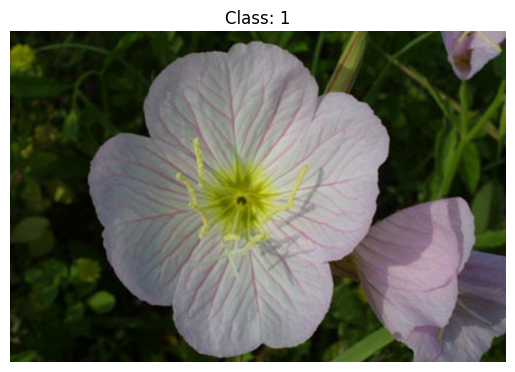

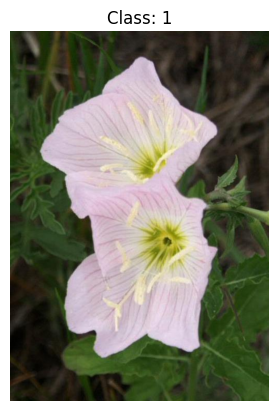

In [7]:
from PIL import Image

# Paths to your dataset files
flower_archive = "/kaggle/input/flower/102flowers.tgz"
labels_file = "/kaggle/input/flower/imagelabels.mat"
setid_file = "/kaggle/input/flower/setid.mat"
output_folder = "/kaggle/working/flowers"

# Step 1: Extract the flower images
print("Extracting flower images...")
with tarfile.open(flower_archive, 'r:gz') as tar:
    tar.extractall(output_folder)

# Step 2: Locate all image files
print("Locating image files...")
all_images = []
for root, _, files in os.walk(output_folder):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):  # Check for image files
            all_images.append(os.path.join(root, file))
all_images.sort()  # Sort to ensure consistent ordering

print(f"Total images found: {len(all_images)}")

# Step 3: Load labels
print("Loading labels...")
labels_data = scipy.io.loadmat(labels_file)
labels = labels_data['labels'].flatten()  # Flatten the array
print(f"Loaded {len(labels)} labels.")

# Step 4: Load train/validation/test splits
print("Loading data splits...")
setid_data = scipy.io.loadmat(setid_file)
train_ids = setid_data['trnid'].flatten()  # Training set indices
valid_ids = setid_data['valid'].flatten()  # Validation set indices
test_ids = setid_data['tstid'].flatten()   # Test set indices

print(f"Number of training samples: {len(train_ids)}")
print(f"Number of validation samples: {len(valid_ids)}")
print(f"Number of test samples: {len(test_ids)}")

# Step 5: Adjust indices for Python (1-based to 0-based)
print("Adjusting indices...")
train_ids = [i - 1 for i in train_ids if i - 1 < len(all_images)]
valid_ids = [i - 1 for i in valid_ids if i - 1 < len(all_images)]
test_ids = [i - 1 for i in test_ids if i - 1 < len(all_images)]

# Step 6: Map image filenames to their labels
image_to_label = {all_images[i]: labels[i] for i in range(len(all_images))}

# Step 7: Display a few training images with their labels
def display_images(images, labels, num_samples=5):
    print("Displaying sample images...")
    for i in range(min(num_samples, len(images))):
        img_path = images[i]
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f"Class: {labels[img_path]}")
        plt.axis('off')
        plt.show()

# Display some training images
train_images = [all_images[i] for i in train_ids]
display_images(train_images, image_to_label, num_samples=5)


# Plotting histogram to observe the distribution of data

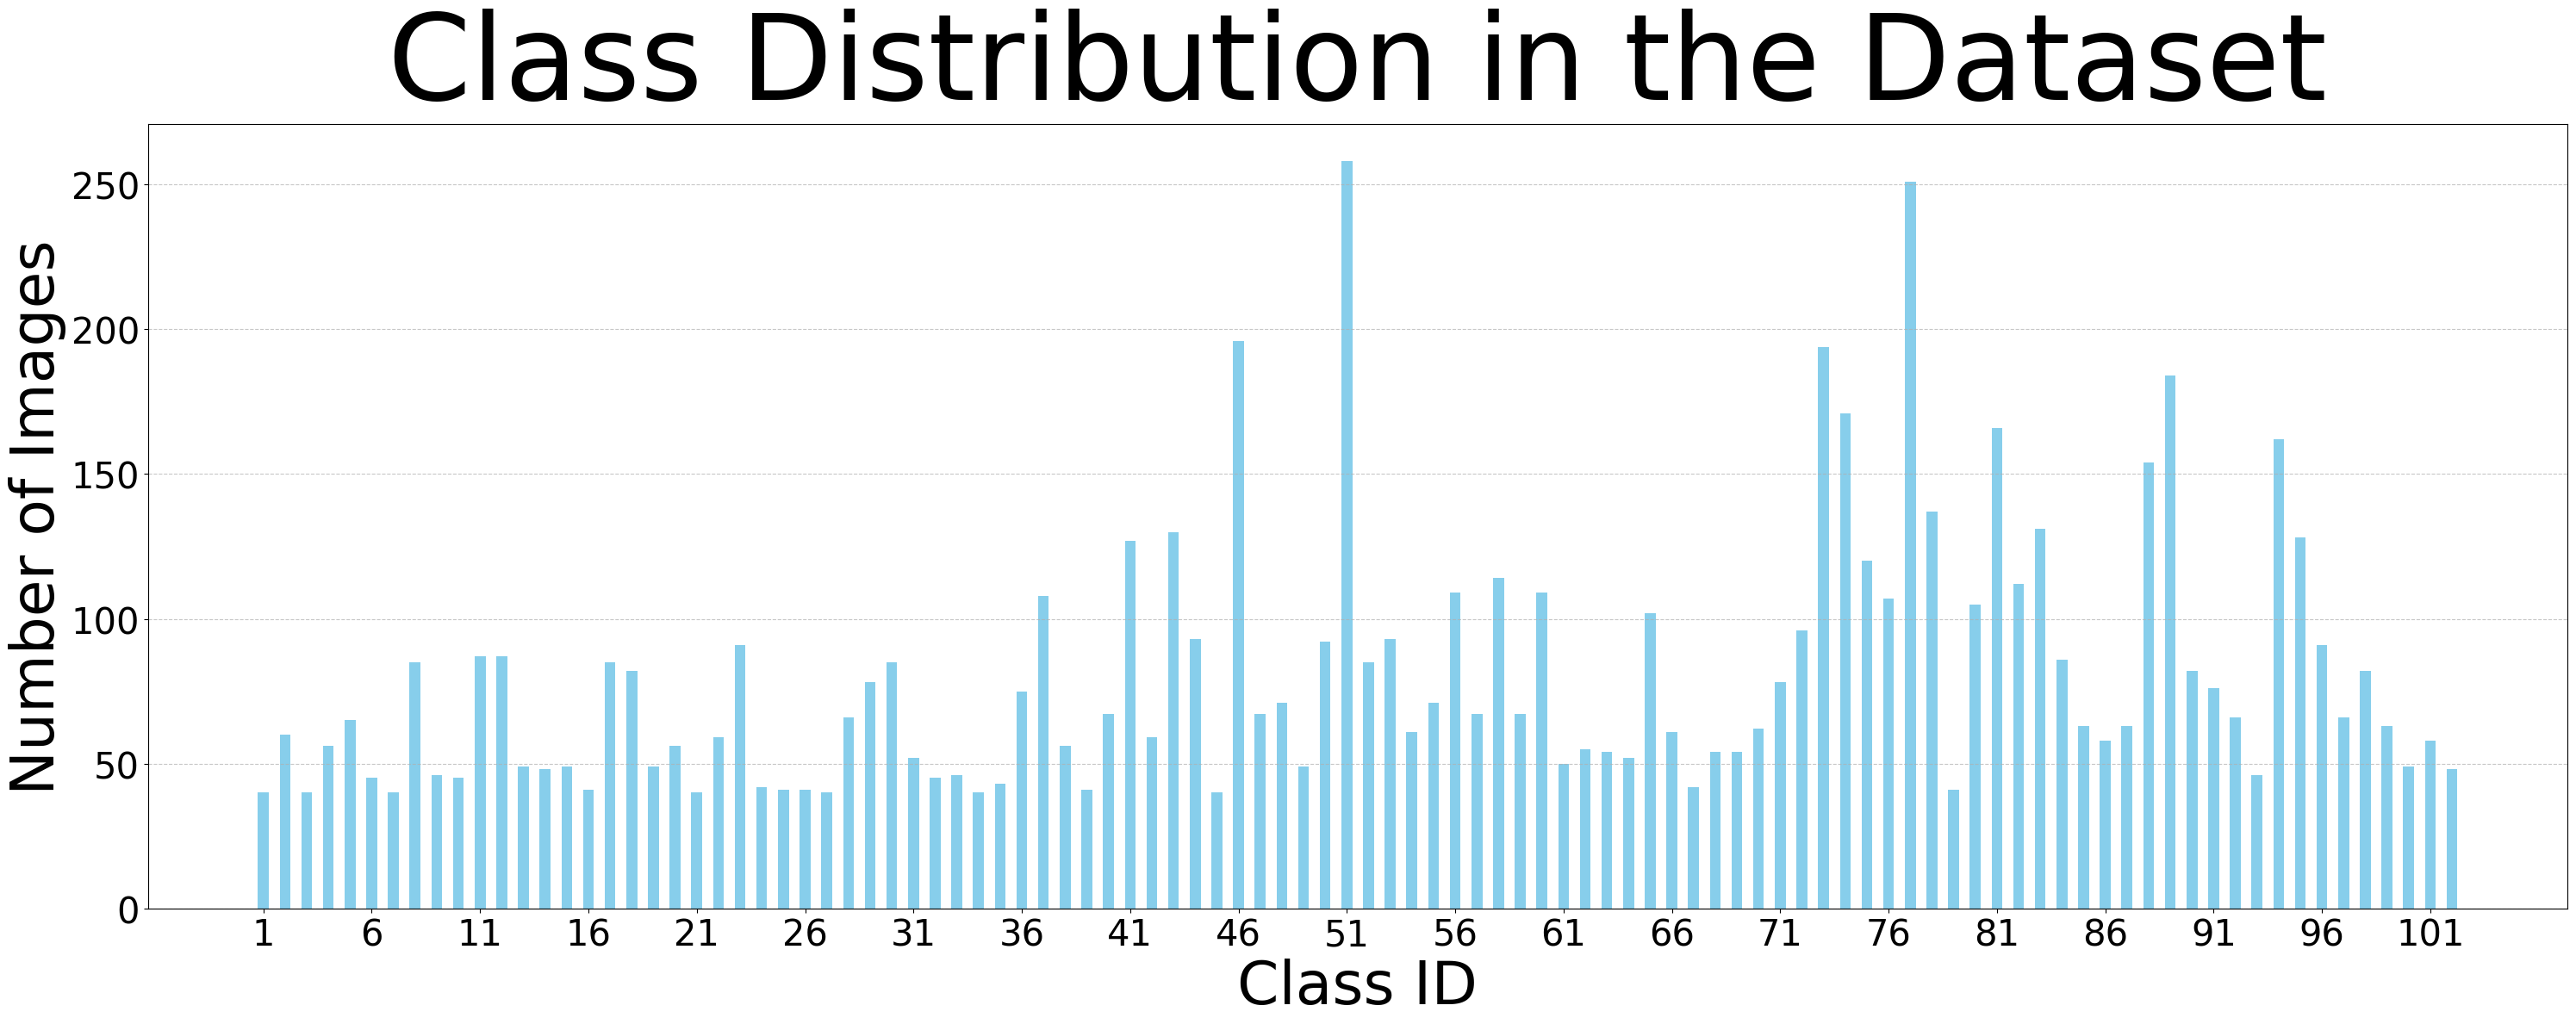

In [8]:
import matplotlib.pyplot as plt
unique_labels, counts = np.unique(labels, return_counts=True)

# Step 1: Adjust figure size for a larger plot
plt.figure(figsize=(30, 12))  

# Step 2: Reduce bar width for better separation
bar_width = 0.5  

# Plot the bar chart
plt.bar(unique_labels, counts, color='skyblue', width=bar_width)  

# Step 3: Adjust x-ticks
n = 5  # Show every 5th label
plt.xticks(unique_labels[::n], rotation=0, fontsize=30)  # Display every nth label
plt.yticks( rotation=0, fontsize=30)  

# Add labels and title with improved font sizes
plt.xlabel('Class ID', fontsize=50)
plt.ylabel('Number of Images', fontsize=50)

plt.title('Class Distribution in the Dataset', fontsize=100)

# Add grid lines for y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Step 4: Add layout padding
plt.tight_layout()

# Show the plot
plt.show()


# converting -1 indexing to 0 base indexing 


In [6]:
# Load labels and splits
labels = scipy.io.loadmat('/kaggle/input/flower/imagelabels.mat')['labels'][0] - 1  # Convert 1-indexed to 0-indexed
setid = scipy.io.loadmat('/kaggle/input/flower/setid.mat')

# Dataset splits
train_ids = setid['trnid'][0] - 1  # Train indices (0-indexed)
val_ids = setid['valid'][0] - 1    # Validation indices
test_ids = setid['tstid'][0] - 1   # Test indices

print(f"Train images: {len(train_ids)}, Validation images: {len(val_ids)}, Test images: {len(test_ids)}")

Train images: 1020, Validation images: 1020, Test images: 6149


# looking headerfile 

In [7]:

# Load the .mat file
mat_contents = scipy.io.loadmat('/kaggle/input/flower/distancematrices102.mat')

# Print the keys in the file
print(mat_contents.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Dsiftint', 'Dhsv', 'Dsiftbdy', 'Dhog'])


# code starts here

# found that the train,val and test sets are not distributed in a proper ratio

In [8]:
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Paths to the dataset
image_dir = './flowers/jpg'
setid_path = '/kaggle/input/flower/setid.mat'
labels_path = '/kaggle/input/flower/imagelabels.mat'

# Load train, validation, and test IDs as its not split into
#Training (70%): ~5732 images
#Validation (15%): ~1228 images
#Test (15%)

setid = scipy.io.loadmat(setid_path)
train_ids = setid['trnid'].flatten() - 1  # Convert to 0-based indexing
val_ids = setid['valid'].flatten() - 1    # Convert to 0-based indexing
test_ids = setid['tstid'].flatten() - 1   # Convert to 0-based indexing

# Load labels and one-hot encode
labels = scipy.io.loadmat(labels_path)['labels'].flatten() - 1  # Convert to 0-based indexing

# Create a full list of image IDs
image_ids = np.arange(len(labels))

# Split into 70% train, 15% validation, and 15% test
train_ids, temp_ids = train_test_split(
    image_ids, test_size=0.3, random_state=42, stratify=labels
)
val_ids, test_ids = train_test_split(
    temp_ids, test_size=0.5, random_state=42, stratify=labels[temp_ids]
)

print(f"Train images: {len(train_ids)}, Validation images: {len(val_ids)}, Test images: {len(test_ids)}")

# print(f"Train images: {len(train_ids)}, Validation images: {len(val_ids)}, Test images: {len(test_ids)}")





Train images: 5732, Validation images: 1228, Test images: 1229


In [9]:
# One-hot encode labels
y_train = to_categorical(labels[train_ids], num_classes=102)
y_val = to_categorical(labels[val_ids], num_classes=102)
y_test = to_categorical(labels[test_ids], num_classes=102)

# Preprocessing

In [10]:
def preprocess_images(image_ids, labels, image_dir, target_size=(224, 224)):
    def load_image(idx):
        img_path = os.path.join(image_dir, f"image_{idx+1:05d}.jpg")
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        return img_array

    images = np.array([load_image(idx) for idx in image_ids])

    # Apply preprocessing specific to ResNet50 (normalization)
    images = preprocess_input(images)

    return images, labels

# Preprocess train, validation, and test images
X_train_raw, y_train = preprocess_images(train_ids, y_train, image_dir)
X_val_raw, y_val = preprocess_images(val_ids, y_val, image_dir)
X_test_raw, y_test = preprocess_images(test_ids, y_test, image_dir)


In [11]:
# Check shapes of the output variables
print(f"X_train_raw shape: {X_train_raw.shape}, y_train shape: {y_train.shape}")
print(f"X_val_raw shape: {X_val_raw.shape}, y_val shape: {y_val.shape}")
print(f"X_test_raw shape: {X_test_raw.shape}, y_test shape: {y_test.shape}")

X_train_raw shape: (5732, 224, 224, 3), y_train shape: (5732, 102)
X_val_raw shape: (1228, 224, 224, 3), y_val shape: (1228, 102)
X_test_raw shape: (1229, 224, 224, 3), y_test shape: (1229, 102)


# Dataset Creation and Preprocessing

In [12]:
# Batch size
batch_size = 32


# Function to create datasets
def create_dataset(images, labels, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if augment:
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            # tf.keras.layers.RandomRotation(0.2),
            # tf.keras.layers.RandomZoom(0.1),
        ])
        dataset = dataset.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    
    # both augmented and non-augmented images are normalized using preprocess_input for ResNet50
    dataset = dataset.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    #shuffle:ensures the data order is random,cache:reduces redundant computation,speedup epoche,Prefetching :minimizes idle time
    dataset = dataset.shuffle(1000).batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create training, validation, and test datasets
train_ds = create_dataset(X_train_raw, y_train, augment=True)
val_ds = create_dataset(X_val_raw, y_val, augment=False)
test_ds = create_dataset(X_test_raw, y_test, augment=False)


# Model Architecture


In [13]:
# Load ResNet50 with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)# Reduces the spatial dimensions (e.g., 7x7 feature maps) to a single vector
hidden_layer = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)  # L2 regularization added
hidden_layer = BatchNormalization()(hidden_layer)
hidden_layer = Dropout(0.7)(hidden_layer)
output_layer = Dense(102, activation='softmax')(hidden_layer)

# Combine base model and custom layers
model_cnn = Model(inputs=base_model.input, outputs=output_layer)


# Model Compilation

In [14]:
# Learning rate schedule (Exponential Decay)
#adjusts the learning rate over time by gradually reducing it as training progresses.
#Avoid oscillations or overshooting during training.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9
)

# Compile the model
model_cnn.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Model Training

In [15]:
# Callbacks for learning rate adjustment and early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_cnn = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=26,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model_cnn.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/26


I0000 00:00:1732171803.222428    1026 service.cc:145] XLA service 0x7f027c14da40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732171803.222488    1026 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732171803.222494    1026 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/180 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.0000e+00 - loss: 8.3053 

I0000 00:00:1732171811.010475    1026 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


180/180 ━━━━━━━━━━━━━━━━━━━━ 57s 211ms/step - accuracy: 0.0355 - loss: 6.8293 - val_accuracy: 0.4080 - val_loss: 3.5630
Epoch 2/26
180/180 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - accuracy: 0.2443 - loss: 4.2343 - val_accuracy: 0.6124 - val_loss: 2.5750
Epoch 3/26
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.4240 - loss: 3.2205 - val_accuracy: 0.6954 - val_loss: 2.1460
Epoch 4/26
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.5178 - loss: 2.7601 - val_accuracy: 0.7557 - val_loss: 1.8935
Epoch 5/26
180/180 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.6080 - loss: 2.3547 - val_accuracy: 0.7940 - val_loss: 1.7304
Epoch 6/26
180/180 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.6619 - loss: 2.0955 - val_accuracy: 0.8184 - val_loss: 1.5989
Epoch 7/26
180/180 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.7133 - loss: 1.8903 - val_accuracy: 0.8379 - val_loss: 1.5206
Epoch 8/26
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.7459 - loss: 1.7326 - val

#  Plot Training and Validation Metrics

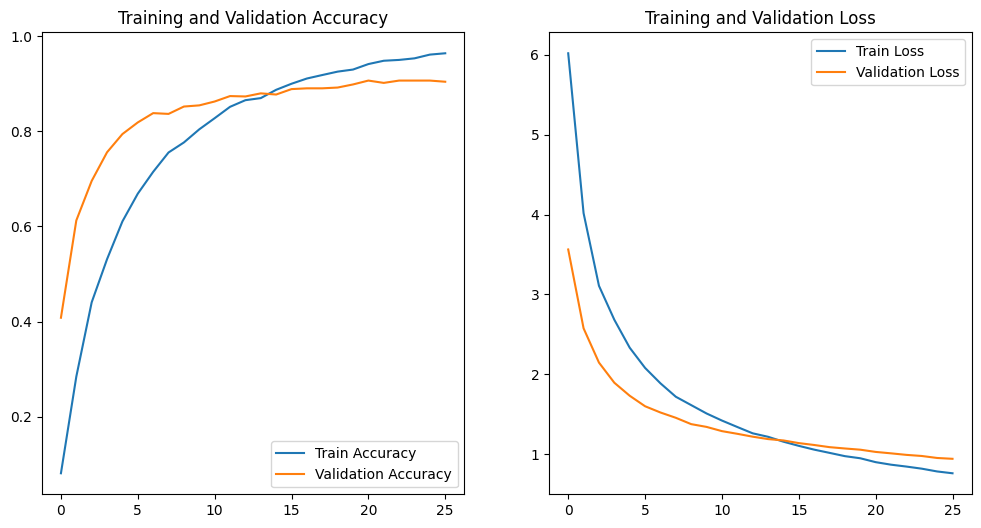

In [16]:
# Plotting the results
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Plot the training and validation metrics
plot_training(history_cnn)


# BEST 

In [23]:
from tensorflow.keras.models import save_model

# Save the trained model
model_cnn.save('flower_resnet_model_final.h5')
